In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# content: https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda
# url2: https://fred.stlouisfed.org/series/DJFUELUSGULF => Fuel price (USD/gallon)
# url3: https://www.iata.org/en/publications/economics/fuel-monitor/ => IATA Fuel Monitor
# url4: https://www.bts.gov/content/national-level-domestic-average-fare-series => National Lever Domestic Avg. Fare (US)
# url5: https://data.bls.gov/timeseries/CUUR0000SA0L1E?output_view=pct_12mths => American Inflation Historical Data
# url6: https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=pet&s=f000000__3&f=a => Oil barrel price

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Auth|Path libs
import os
import warnings
warnings.filterwarnings('ignore')
# Basic libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
# Statsmodels methods
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARIMA
# Math lib
import math
# Sklearn methods
from sklearn.metrics import mean_squared_error

In [ ]:
# Read .csv and .xlsx
df1 = pd.read_csv('Jet_Fuel_Price_1990_2024.csv') # Kerosene-Type Jet Fuel Prices: U.S. Gulf Coast
df2 = pd.read_excel('Quarterly national level domestic average fare series 4Q 2023.xlsx')

In [ ]:
pd.set_option('display.max_rows', 9000) # See if there's NaN or None values
df1.rename(columns={
    'DATE':'Date',
    'DJFUELUSGULF':'Dollars per Gallon (USD/gallon)'
}, inplace=True)
df1.tail()
# df1 -> must be on the same parameters, quartly {[1991-01-01:1991-04-01] = 1
# mean(df['Date].iloc[:])

,Date,Dollars per Gallon (USD/gallon)
8909,2024-05-24,2.336
8910,2024-05-27,.
8911,2024-05-28,2.401
8912,2024-05-29,2.353
8913,2024-05-30,2.294


In [ ]:
# Replacing "." values for the mean() of the 4th last values
def replace_dot_with_mean(df, column):
    df1['Dollars per Gallon (USD/gallon)'] = pd.to_numeric(df1['Dollars per Gallon (USD/gallon)'], errors='coerce')

    for i in range(len(df1)):
        if pd.isna(df1.at[i, 'Dollars per Gallon (USD/gallon)']):  # Check for NaN values
            # Calculate the mean of the last 4 valid values
            if i >= 4:
                mean_value = df1['Dollars per Gallon (USD/gallon)'][i-4:i].mean()
            else:
                mean_value = df1['Dollars per Gallon (USD/gallon)'][:i].mean()  # Adjust if there are fewer than 4 previous values

            # Replace the NaN with the calculated mean value
            df1.at[i, 'Dollars per Gallon (USD/gallon)'] = mean_value

replace_dot_with_mean(df1, 'Value')

df1.tail()

,Date,Dollars per Gallon (USD/gallon)
8909,2024-05-24,2.33600
8910,2024-05-27,2.35775
8911,2024-05-28,2.40100
8912,2024-05-29,2.35300
8913,2024-05-30,2.29400


In [ ]:
# Convert df1['Date'] to datetime
df1['Date']= pd.to_datetime(df1['Date'])
df1.dtypes

Date                               datetime64[ns]
Dollars per Gallon (USD/gallon)           float64
dtype: object

In [ ]:
# Descritive statistics
df1['Dollars per Gallon (USD/gallon)'].describe()

count    8914.000000
mean        1.524685
std         0.949282
min         0.282000
25%         0.623000
50%         1.396000
75%         2.147000
max         5.066000
Name: Dollars per Gallon (USD/gallon), dtype: float64

In [ ]:
# Create a 'Quarter' column
df1['Year'] = df1['Date'].dt.year # New 'Year' columns => to match the df2['Year'] column
df1['Quarter'] = df1['Date'].dt.quarter # New 'Quarter' columns => to match the df2['Quarter'] column
df1['Dollars per Gallon (USD/gallon)'] = df1['Dollars per Gallon (USD/gallon)'].astype(float)  # Convert formatted string values back to float for aggregation
quarterly_aggregate = df1.groupby(['Year', 'Quarter'])['Dollars per Gallon (USD/gallon)'].mean().reset_index()
df_aux = quarterly_aggregate.iloc[19:135] # Match the similar df2
df_aux.head()

,Year,Quarter,Dollars per Gallon (USD/gallon)
19,1995,1,0.462427
20,1995,2,0.496642
21,1995,3,0.491942
22,1995,4,0.526063
23,1996,1,0.564285


In [ ]:
# Reset the daframe's indexes => prepare to join df2 already set.
df_aux.reset_index()

,index,Year,Quarter,Dollars per Gallon (USD/gallon)
0,19,1995,1,0.462427
1,20,1995,2,0.496642
2,21,1995,3,0.491942
3,22,1995,4,0.526063
4,23,1996,1,0.564285
5,24,1996,2,0.564504
6,25,1996,3,0.614867
7,26,1996,4,0.697436
8,27,1997,1,0.620676
9,28,1997,2,0.537823


In [ ]:
df2.head()

,Year,Quarter,U.S. Average (Current $),U.S. Average (Inflation-Adjusted $)
0,1995,1,296.895553,604.462553
1,1995,2,296.462724,598.293721
2,1995,3,287.514840,577.705460
3,1995,4,287.776292,575.470149
4,1996,1,283.969692,562.728998


In [ ]:
df_final =  pd.merge(df_aux, df2, on=('Year', 'Quarter'))

In [ ]:
df_final.head()

,Year,Quarter,Dollars per Gallon (USD/gallon),U.S. Average (Current $),U.S. Average (Inflation-Adjusted $)
0,1995,1,0.462427,296.895553,604.462553
1,1995,2,0.496642,296.462724,598.293721
2,1995,3,0.491942,287.514840,577.705460
3,1995,4,0.526063,287.776292,575.470149
4,1996,1,0.564285,283.969692,562.728998


In [ ]:
df_final[['Year','Quarter']] = df_final[['Year', 'Quarter']].astype(str)

In [ ]:
df_final.dtypes

Year                                     object
Quarter                                  object
Dollars per Gallon (USD/gallon)         float64
U.S. Average (Current $)                float64
U.S. Average (Inflation-Adjusted $)     float64
dtype: object

In [ ]:
def ultimo_dia_quarter(ano, quarter):
    if quarter == '1':
        return f"{ano}-03-31"
    elif quarter == '2':
        return f"{ano}-06-30"
    elif quarter == '3':
        return f"{ano}-09-30"
    elif quarter == '4':
        return f"{ano}-12-31"
    else:
        return 'Quarter inválido'

In [ ]:
df_final['data_final_quarter'] = df_final.apply(lambda row: ultimo_dia_quarter(row['Year'], row['Quarter']), axis=1)

In [ ]:
df_final.head()

,Year,Quarter,Dollars per Gallon (USD/gallon),U.S. Average (Current $),U.S. Average (Inflation-Adjusted $),data_final_quarter
0,1995,1,0.462427,296.895553,604.462553,1995-03-31
1,1995,2,0.496642,296.462724,598.293721,1995-06-30
2,1995,3,0.491942,287.514840,577.705460,1995-09-30
3,1995,4,0.526063,287.776292,575.470149,1995-12-31
4,1996,1,0.564285,283.969692,562.728998,1996-03-31


In [ ]:
df_final['data_final_quarter'] = pd.to_datetime(df_final['data_final_quarter'])

In [ ]:
df_final = df_final[['data_final_quarter','Dollars per Gallon (USD/gallon)', 'U.S. Average (Current $) ','U.S. Average (Inflation-Adjusted $) ' ]]

In [ ]:
df_final.head()

,data_final_quarter,Dollars per Gallon (USD/gallon),U.S. Average (Current $),U.S. Average (Inflation-Adjusted $)
0,1995-03-31,0.462427,296.895553,604.462553
1,1995-06-30,0.496642,296.462724,598.293721
2,1995-09-30,0.491942,287.514840,577.705460
3,1995-12-31,0.526063,287.776292,575.470149
4,1996-03-31,0.564285,283.969692,562.728998


In [ ]:
dy = df_final['Dollars per Gallon (USD/gallon)'].diff(periods=1)
gt = np.log(df_final['Dollars per Gallon (USD/gallon)']).diff(periods=1)
ga = np.log(df_final['Dollars per Gallon (USD/gallon)']).diff(periods=4)

In [ ]:
dy2 = df_final['U.S. Average (Inflation-Adjusted $) '].diff(periods=1)
gt2 = np.log(df_final['U.S. Average (Inflation-Adjusted $) ']).diff(periods=1)
ga2 = np.log(df_final['U.S. Average (Inflation-Adjusted $) ']).diff(periods=4)

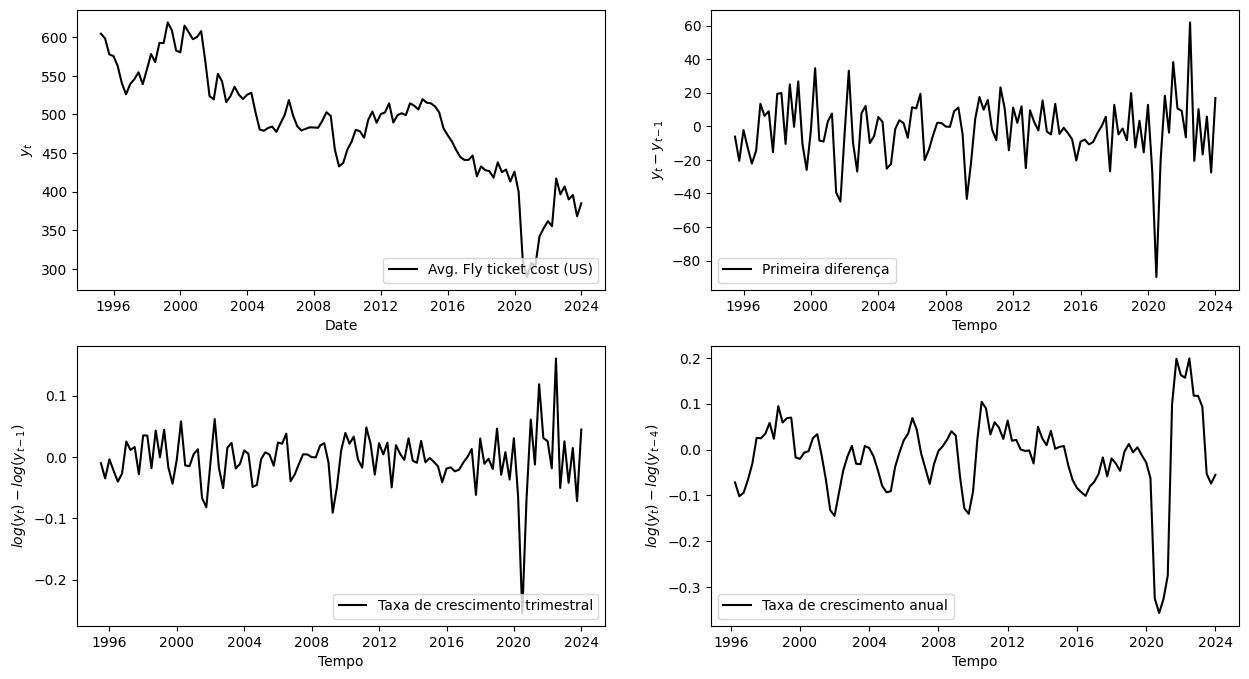

In [ ]:
fig = plt.figure(figsize=(15,8))

painel_1b = fig.add_subplot(2, 2, 1) # 2 linhas, 2 colunas, ocupa posição 1
plt.plot(df_final['data_final_quarter'], df_final['U.S. Average (Inflation-Adjusted $) '], color="black", label="Avg. Fly ticket cost (US)")
plt.xlabel("Date")
plt.ylabel("$y_t$")
plt.legend(loc="lower right") # Plota legenda e define a localização

painel_2b = fig.add_subplot(2, 2, 2) # 2 linhas, 2 colunas, ocupa posição 2
plt.plot(df_final['data_final_quarter'], dy2, color="black", label="Primeira diferença" )
plt.xlabel("Tempo")
plt.ylabel("$y_t - y_{t-1}$")
plt.legend(loc="lower left") # Plota legenda e define a localização

painel_3b = fig.add_subplot(2, 2, 3) # 2 linhas, 2 colunas, ocupa posição 3
plt.plot(df_final['data_final_quarter'], gt2, color="black", label="Taxa de crescimento trimestral")
plt.xlabel("Tempo")
plt.ylabel("$log(y_t) - log(y_{t-1})$")
plt.legend(loc="lower right")

painel_4b = fig.add_subplot(2, 2, 4) # 2 linhas, 2 colunas, ocupa posição 4
plt.plot(df_final['data_final_quarter'], ga2, color="black", label="Taxa de crescimento anual")
plt.xlabel("Tempo")
plt.ylabel("$log(y_t) - log(y_{t-4})$")
plt.legend(loc="lower left")

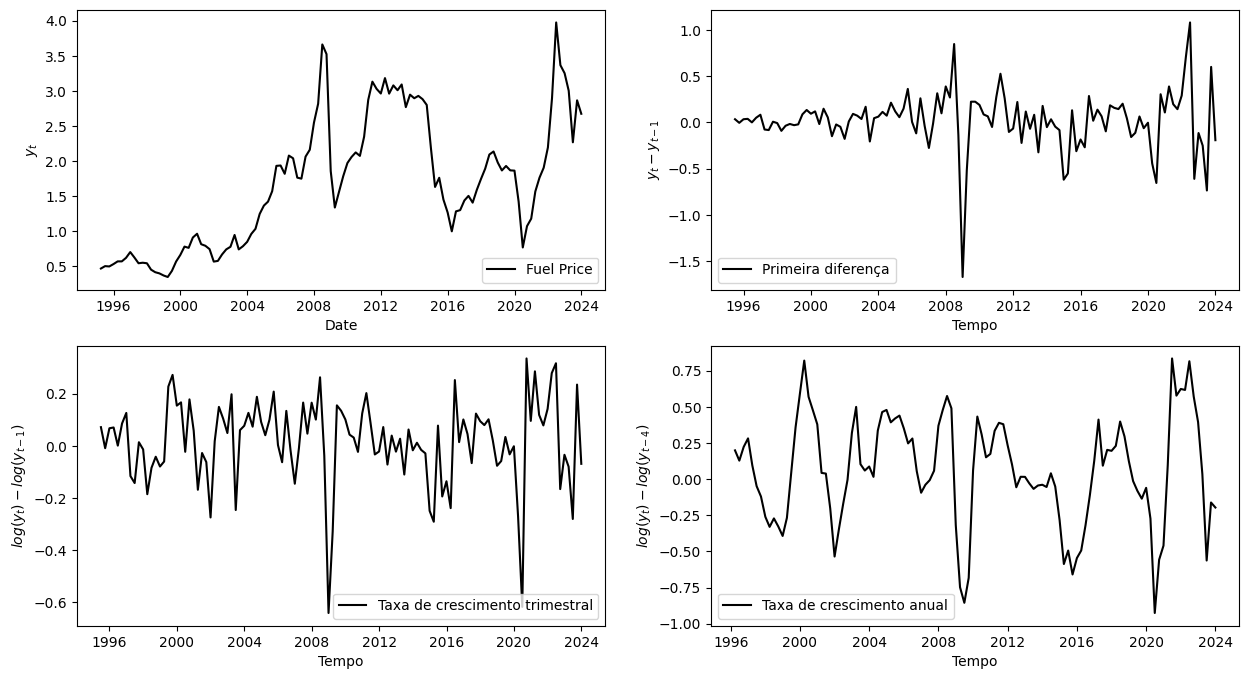

In [ ]:
fig = plt.figure(figsize=(15,8))

painel_1a = fig.add_subplot(2, 2, 1) # 2 linhas, 2 colunas, ocupa posição 1
plt.plot(df_final['data_final_quarter'], df_final['Dollars per Gallon (USD/gallon)'], color="black", label="Fuel Price")
plt.xlabel("Date")
plt.ylabel("$y_t$")
plt.legend(loc="lower right") # Plota legenda e define a localização

painel_2a = fig.add_subplot(2, 2, 2) # 2 linhas, 2 colunas, ocupa posição 2
plt.plot(df_final['data_final_quarter'], dy, color="black", label="Primeira diferença" )
plt.xlabel("Tempo")
plt.ylabel("$y_t - y_{t-1}$")
plt.legend(loc="lower left") # Plota legenda e define a localização

painel_3a = fig.add_subplot(2, 2, 3) # 2 linhas, 2 colunas, ocupa posição 3
plt.plot(df_final['data_final_quarter'], gt, color="black", label="Taxa de crescimento trimestral")
plt.xlabel("Tempo")
plt.ylabel("$log(y_t) - log(y_{t-1})$")
plt.legend(loc="lower right")

painel_4a = fig.add_subplot(2, 2, 4) # 2 linhas, 2 colunas, ocupa posição 4
plt.plot(df_final['data_final_quarter'], ga, color="black", label="Taxa de crescimento anual")
plt.xlabel("Tempo")
plt.ylabel("$log(y_t) - log(y_{t-4})$")
plt.legend(loc="lower left")


In [ ]:
Y = df1['Dollars per Gallon (USD/gallon)']

In [ ]:
Y = ga.dropna()
Y.describe()

count    112.000000
mean       0.060475
std        0.370627
min       -0.925867
25%       -0.141723
50%        0.058783
75%        0.352947
max        0.834868
Name: Dollars per Gallon (USD/gallon), dtype: float64

In [ ]:
from statsmodels.tsa import stattools

fac = stattools.acf(Y, nlags=36)
facp = stattools.pacf(Y, nlags=36)

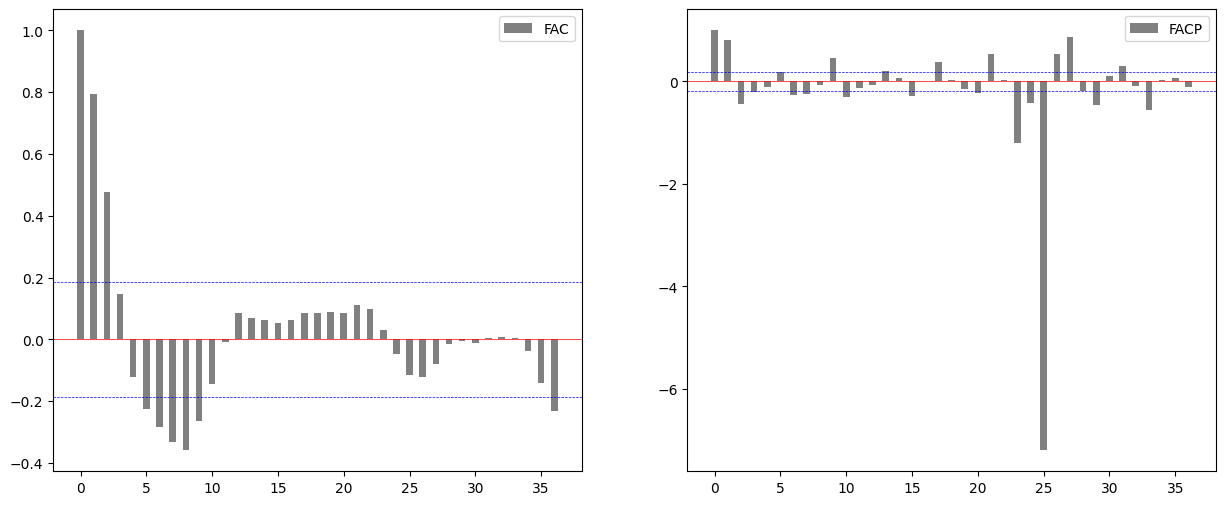

In [ ]:
index = list(range(len(fac)))
fig = plt.figure(figsize=(15,6))
painel_1 = fig.add_subplot(1,2,1)
plt.bar(index, fac, width=0.5, color='grey', label="FAC")
#plt.stem(index, fac, color='grey', label="FAC") # opção: gráfico similar ao do matlab
plt.axhline(0, color='red', lw=0.5)
plt.axhline((1.96/np.sqrt(len(Y))), color='blue', linestyle = "--", lw=0.5)
plt.axhline(-(1.96/np.sqrt(len(Y))), color='blue', linestyle = "--", lw=0.5)
plt.legend(loc="upper right")


painel_2 = fig.add_subplot(1,2,2)
plt.bar(index, facp, width=0.5, color='grey', label="FACP")
plt.axhline(0, color='red', lw=0.5)
plt.axhline((1.96/np.sqrt(len(Y))), color='blue', linestyle = "--", lw=0.5)
plt.axhline(-(1.96/np.sqrt(len(Y))), color='blue', linestyle = "--", lw=0.5)
plt.legend(loc="upper right")

In [ ]:
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore",category=FutureWarning)
modelo = ARIMA(Y, order=(1,0,0)) # Cria um objeto contendo o modelo arima(1,0,0)
modelo_fit = modelo.fit() # Ajusta o modelo
print(modelo_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:     Dollars per Gallon (USD/gallon)   No. Observations:                  112
Model:                              ARIMA(1, 0, 0)   Log Likelihood                   8.361
Date:                             Fri, 21 Jun 2024   AIC                            -10.723
Time:                                     18:45:30   BIC                             -2.567
Sample:                                          0   HQIC                            -7.414
                                             - 112                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0567      0.103      0.551      0.582      -0.145       0.259
ar.L1          0.7908      

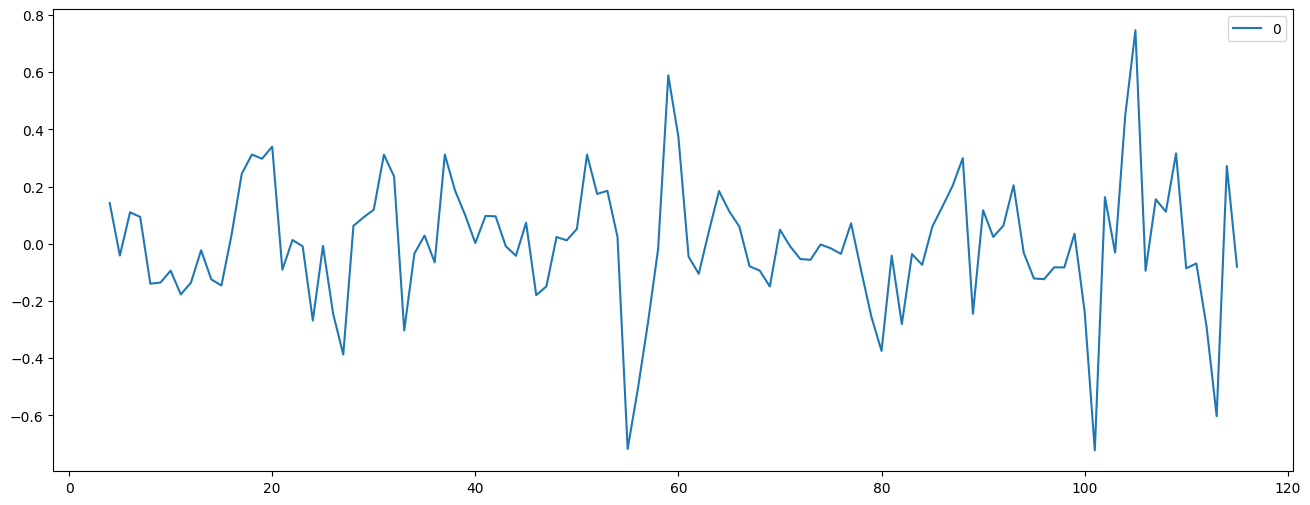

In [ ]:
residuals = pd.DataFrame(modelo_fit.resid)
residuals.plot()
plt.show()

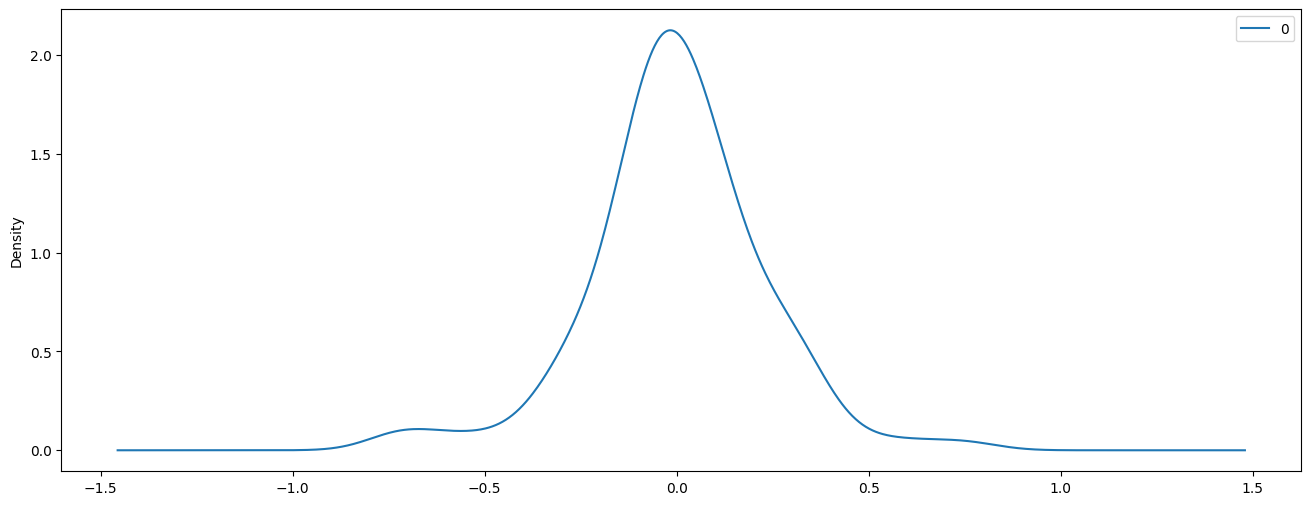

                0
count  112.000000
mean    -0.001005
std      0.224839
min     -0.721739
25%     -0.094557
50%     -0.008781
75%      0.112276
max      0.745984


In [ ]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
yhat = modelo_fit.forecast(steps=20, alpha=0.05)
IC = modelo_fit.forecast(steps=20, alpha=0.05)

In [ ]:
passos = pd.period_range(start="2019-12-30", end="2024-09-30", freq="Q-DEC") # Cria um índice
passos = passos.to_timestamp(how='end')

In [ ]:
y = ga.dropna()

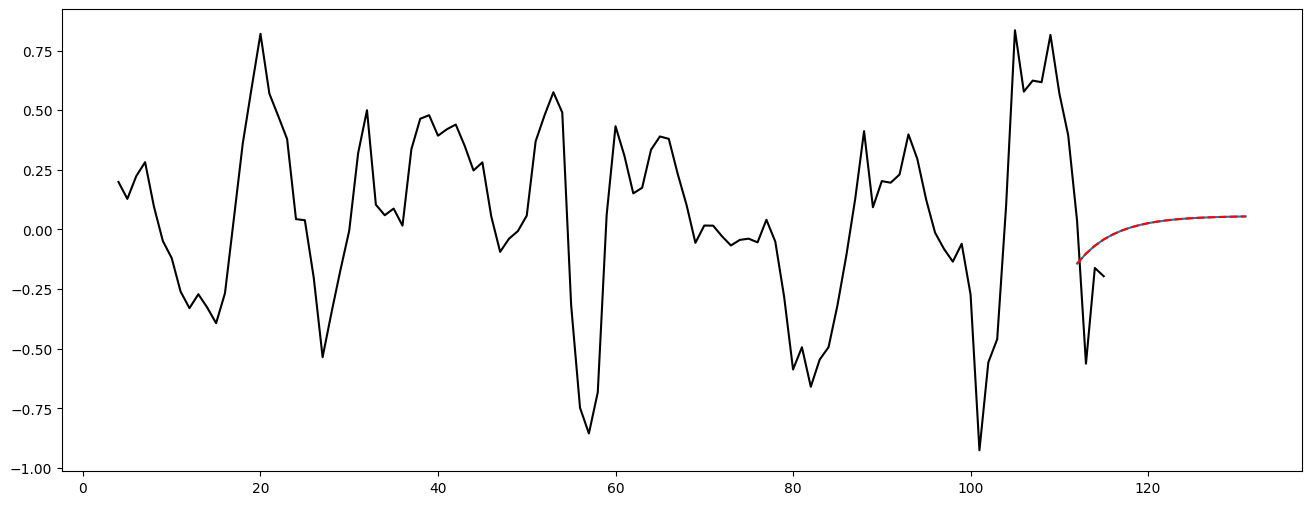

In [ ]:
plt.plot(y, color='black')
plt.plot(yhat)
plt.plot(IC, '--', color='red')
plt.show()

As you can see from plot above, our time series has *seasonal variation*.

Check stationarity using the following methods:
* Plotting Rolling Statistics: We have a window lets say window size is 6 and then we find rolling mean and variance to check stationary.
* Dickey-Fuller Test: The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the test statistic is less than the critical value, we can say that time series is stationary.

In [ ]:
# Create a Time Series => Z(t)
timeSeries = df1.loc[:, ['Date','Dollars per Gallon (USD/gallon)']]
timeSeries.index = timeSeries.Date
ts = timeSeries.drop("Date",axis=1)
ts.head()

,Dollars per Gallon (USD/gallon)
Date,
1990-04-02,0.550
1990-04-03,0.555
1990-04-04,0.560
1990-04-05,0.540
1990-04-06,0.536


In [ ]:
# Dickey-Fuller Test to check stationarity from statsmodels lib
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ga):
    result = adfuller(ga)
    # Statistical results
    print('Test Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Return the results as a dictionary
    return {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4],
        'Stationarity': result[1] < 0.05  # Limit 0.05 < p-value
    }

results = check_stationarity(ts)

# Interpret the results
if results['Stationarity']:
    print('A Série Temporal é estacionária')
else:
    print('A Série Temporal NÃO é estacionária')

TypeError: float() argument must be a string or a real number, not 'module'

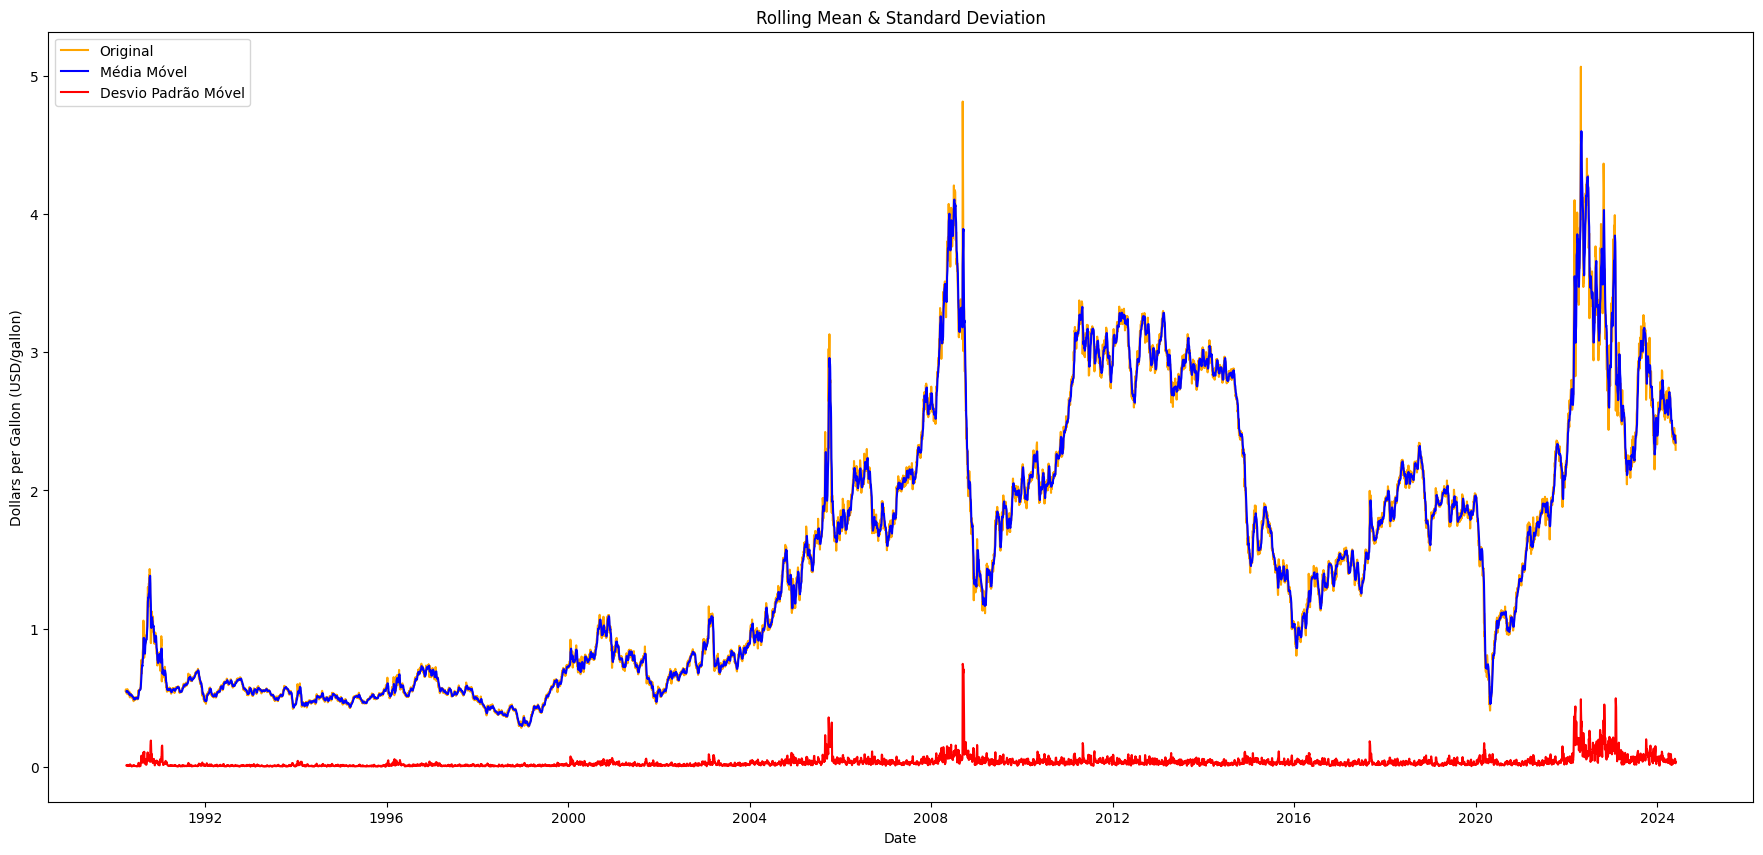

In [ ]:
# Check mean standard deviation
def mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(window=6).mean()
    rolstd = ts.rolling(window=6).std()
    plt.figure(figsize=(22,10))
    orig = plt.plot(ts, color='orange',label='Original')
    mean = plt.plot(rolmean, color='blue', label='Média Móvel')
    std = plt.plot(rolstd, color='red', label = 'Desvio Padrão Móvel')
    plt.xlabel("Date")
    plt.ylabel("Dollars per Gallon (USD/gallon)")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

mean_std(ts)

#Parameters for NON-stationarity:
* Our first criteria for stationary is "Média Movel". So we fail because mean is not constant as you can see from plot(blue line) above.
* Second one is constant variance. It looks like constant. (yes stationary)
* Third one is that If the test statistic is less than the critical value, we can say that time series is stationary. Lets look:
test statistic = -1.4 and critical values = {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}. Test statistic is bigger than the critical values. (no stationary).
* _As a result, we are sure that our time series is not stationary._

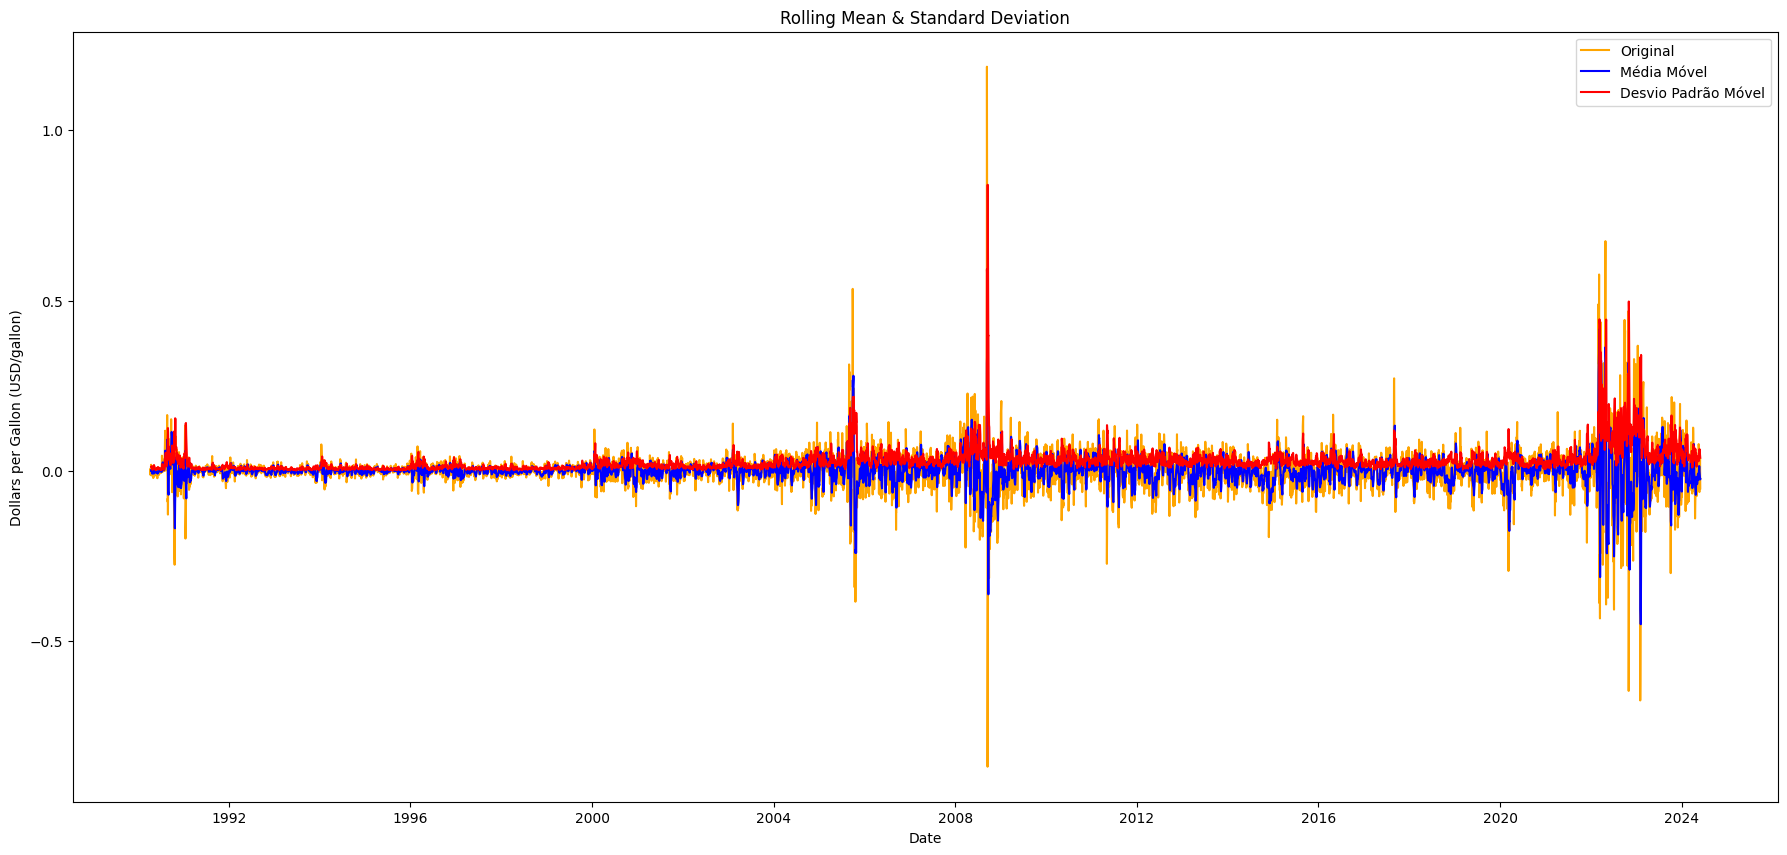

In [ ]:
rolmean = ts.rolling(window=6).mean()
ts_moving_avg_diff = ts - rolmean
ts_moving_avg_diff.dropna(inplace=True) # Window size set to 6 as default parameter

# Check if the Time Series satisfies the stationarity statement
mean_std(ts_moving_avg_diff)

In [ ]:
results = check_stationarity(ts_moving_avg_diff)

# Interpret the results
if results['Stationarity']:
    print('A Série Temporal é estacionária')
else:
    print('A Série Temporal NÃO é estacionária')

Test Statistic: -17.813705733606575
p-value: 3.181585031097812e-30
Critical Values: {'1%': -3.431086454728276, '5%': -2.8618654646703425, '10%': -2.5669432398398557}
A Série Temporal é estacionária


In [ ]:
lag_acf = acf(ts_moving_avg_diff, nlags=20)
lag_pacf = pacf(ts_moving_avg_diff, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))

<Figure size 2200x1000 with 0 Axes>

<Figure size 2200x1000 with 0 Axes>

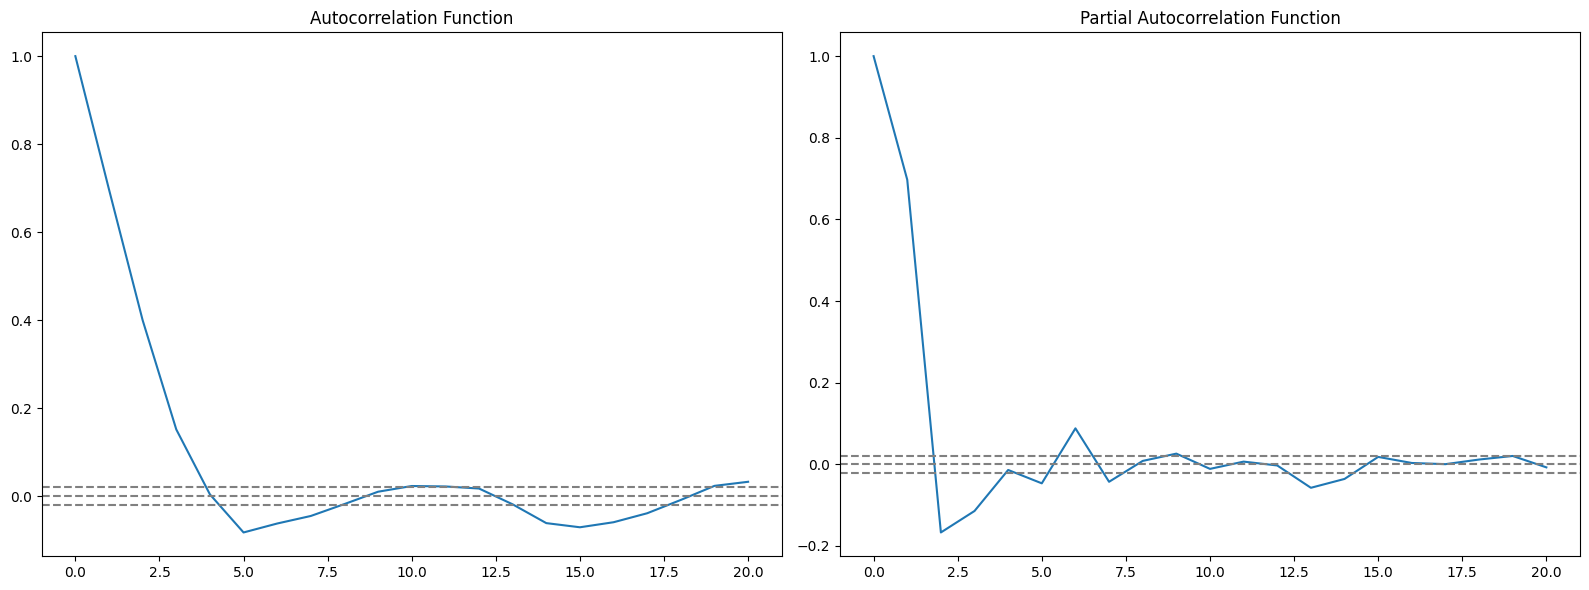

In [ ]:
# ACF and PACF
from statsmodels.tsa.stattools import acf, pacf

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray') # Intervalo de Confiança
plt.axhline(y=1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray') # Intervalo de Confiança
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray') # Intervalo de Confiança
plt.axhline(y=1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray') # Intervalo de Confiança
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

### Essa parte ainda ta meio shady

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from statsmodels.graphics.tsaplots import plot_predict

rcParams['figure.figsize'] = 16, 6
model = ARIMA(ts['Dollars per Gallon (USD/gallon)'].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8913
Model:                 ARIMA(2, 1, 0)   Log Likelihood               12301.537
Date:                Fri, 21 Jun 2024   AIC                         -24597.073
Time:                        12:56:04   BIC                         -24575.788
Sample:                             0   HQIC                        -24589.827
                               - 8913                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6181      0.003   -190.746      0.000      -0.624      -0.612
ar.L2         -0.2976      0.003   -116.105      0.000      -0.303      -0.293
sigma2         0.0037   8.65e-06    427.944      0.0

In [ ]:
rmse = math.sqrt(mean_squared_error(ts['Dollars per Gallon (USD/gallon)'].diff().iloc[700:1001].values,
                                    result.predict(start=700,end=1000)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.00821016363052221.


### FORECASTING + ANÁLISE DE RESULTADOS
